# Natural language processing

Practical course material for the ASDM Class 09 (Text Mining) by Florian Leitner.

© 2016-2017 Florian Leitner. All rights reserved.

## Installation and setup

Most of the setup from yesterday for sequence tagging/entity extraction will be re-used today:  SpaCy, and NLTK's wrappers for Stanford CoreNLP libraries.

In [1]:
from nltk.parse.corenlp import CoreNLPDependencyParser
import spacy

This time, we will directly use the CoreNLP API from Stanford, so you need to download the latest CoreNLP package and the two English language model JARs from [the CoreNLP website](https://stanfordnlp.github.io/CoreNLP/), put them all into a directory named `corenlp`, itself located in the same directory as this notebook, and then run the [CoreNLP Server](https://stanfordnlp.github.io/CoreNLP/corenlp-server.html).

If you are using OSX or Linux and have `wget` installed, you can simply run the code below in a terminal to "generate" the required configuration described above:

```bash
wget http://nlp.stanford.edu/software/stanford-corenlp-full-2017-06-09.zip
unzip stanford-corenlp-full-2017-06-09.zip
cd stanford-corenlp-full-2017-06-09
wget http://nlp.stanford.edu/software/stanford-english-corenlp-2017-06-09-models.jar
wget http://nlp.stanford.edu/software/stanford-english-kbp-corenlp-2017-06-09-models.jar
```

As described in the CoreNLP documentation, to run the CoreNLP server, next execute (in that newly created directory):

```bash
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -timeout 15000 -port 9000
```

Timeout values are given in miliseconds, so we tell the parser to abort parsing after 15 seconds.
The default port for the CoreNLP server is 9000 (and can therefore be left out from the above command).

With the server up and running, [the NLTK corenlp API](http://www.nltk.org/api/nltk.parse.html?highlight=corenlpparser#module-nltk.parse.corenlp) simply acts as a client to the server API:

In [2]:
corenlp = CoreNLPDependencyParser(
    url='http://localhost:9000',
    encoding='utf8')

In [3]:
example = 'The quick brown fox jumps over the lazy dog.'

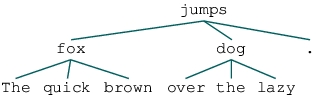

In [4]:
# parse_text returns a *list* of parsed sentences:
corenlp_result, = corenlp.parse_text(example)
corenlp_result.tree()

SpaCy was set up yesterday, but to complete the "proof of life":

In [5]:
spacy_en = spacy.load("en")

In [6]:
spacy_result = spacy_en(example)
spacy_result

The quick brown fox jumps over the lazy dog.

## Visualizing parse results

Thanks to the NLTK wrapper, we are provided with a number of ways to visualize the CoreNLP parse result:

As a simple (but very difficult!) tree/result:

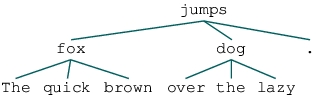

In [7]:
corenlp_result.tree()

The fully dependency-label annotated tree; Notice the tricky attachment of the word "over" (discussed below, in the Comparison section).

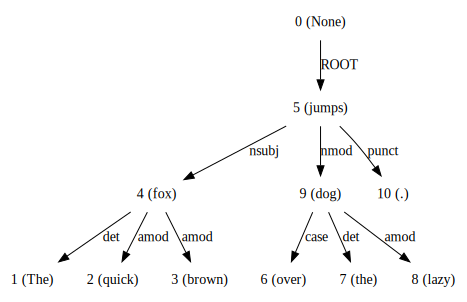

In [8]:
corenlp_result

A very compact and rather standard format, "OTPL" (one token per line), is the 4 column [CONLL Univ. format](http://universaldependencies.org/format.html):

In [9]:
print(corenlp_result.to_conll(4))

The	DT	4	det
quick	JJ	4	amod
brown	JJ	4	amod
fox	NN	5	nsubj
jumps	VBZ	0	ROOT
over	IN	9	case
the	DT	9	det
lazy	JJ	9	amod
dog	NN	5	nmod
.	.	5	punct



We will use that to generate our own output that we can easily compare with SpaCy's result.

In [10]:
def showcore(sentence):
    print("CoreNLP   Token  PoS -dep-> Head\n")
    row = "{: >15s} {: >4s} -{}-> {}"
    lines = sentence.to_conll(4).strip().split('\n')
    words = [line.split('\t') for line in lines]
    tokens = [w[0] for w in words]
    
    for idx, word in enumerate(words):
        token, pos, dep, tag = word
        print(row.format(
            token, pos, tag, tokens[int(dep)-1]))

In [11]:
showcore(corenlp_result)

CoreNLP   Token  PoS -dep-> Head

            The   DT -det-> fox
          quick   JJ -amod-> fox
          brown   JJ -amod-> fox
            fox   NN -nsubj-> jumps
          jumps  VBZ -ROOT-> .
           over   IN -case-> dog
            the   DT -det-> dog
           lazy   JJ -amod-> dog
            dog   NN -nmod-> jumps
              .    . -punct-> jumps


We will need a simple way to visualize the SpaCy results; SpaCy also has a visualizer called [displaCy](https://explosion.ai/blog/displacy-js-nlp-visualizer), but it requires JavaScript and Node.js installed to set up, which is well beyond the scope of this class (hopefully a pure Python solution for Notebooks will come one day...). And the demo doesn't seem to run consistently...

In [12]:
def showcy(sentence):
    print("SpaCy     Token  PoS -dep-> Head\n")
    row = "{: >15s} {: >4s} -{}-> {}"
    
    for token in sentence:
        print(row.format(
            str(token),
            token.tag_,
            token.dep_,
            # make this look like CoreNLP's output:
            token.head if token.head != token else "."))
    
    if sentence.noun_chunks:
        print("\nNOUN PHRASES:")
        for chunk in sentence.noun_chunks:
            print(chunk)

In [13]:
showcy(spacy_result)

SpaCy     Token  PoS -dep-> Head

            The   DT -det-> jumps
          quick   JJ -amod-> jumps
          brown   JJ -amod-> jumps
            fox   NN -nsubj-> jumps
          jumps  VBZ -ROOT-> .
           over   IN -prep-> jumps
            the   DT -det-> dog
           lazy   JJ -amod-> dog
            dog   NN -pobj-> over
              .    . -punct-> jumps

NOUN PHRASES:
fox
the lazy dog


Please refer to the documentaiton for "decyphering" [(Penn Treebank) Part-of-Speech](http://www.clips.ua.ac.be/pages/mbsp-tags) and [(Universal) dependency labels](http://universaldependencies.org/u/dep/index.html); Note that SpaCy still is using the older [Stanford dependency labels](https://nlp.stanford.edu/software/dependencies_manual.pdf) (in case you are not finding a label among the Universal dependency labels).

## Comparing SpaCy and CoreNLP

Finally, lets run some comparisons of the parse results.

We will just look at some qualitative results.
Note that this shouldn't be taken as the final word on this matter and is just here for educative purposes to teach students how to "read" dependency parse results.

In [14]:
showcore(corenlp_result)

CoreNLP   Token  PoS -dep-> Head

            The   DT -det-> fox
          quick   JJ -amod-> fox
          brown   JJ -amod-> fox
            fox   NN -nsubj-> jumps
          jumps  VBZ -ROOT-> .
           over   IN -case-> dog
            the   DT -det-> dog
           lazy   JJ -amod-> dog
            dog   NN -nmod-> jumps
              .    . -punct-> jumps


In [15]:
showcy(spacy_result)

SpaCy     Token  PoS -dep-> Head

            The   DT -det-> jumps
          quick   JJ -amod-> jumps
          brown   JJ -amod-> jumps
            fox   NN -nsubj-> jumps
          jumps  VBZ -ROOT-> .
           over   IN -prep-> jumps
            the   DT -det-> dog
           lazy   JJ -amod-> dog
            dog   NN -pobj-> over
              .    . -punct-> jumps

NOUN PHRASES:
fox
the lazy dog


SpaCy got the attachment of "over" wrong.
This is probsably due to it using the old Stanford depencencies, while the new Universal dependencies provide a new attachment mechanism for prepositions, using a new [`case` dependency](http://universaldependencies.org/u/dep/case.html).
In addition, it did miss the correct attachment of the tokens "The quick brown": Each should be attached to the noun "fox".
Admittedly, SpaCy messed this "classical" example sentence up pretty badly, if compred to CoreNLP.

Going forward, let's simplify this comparison effort:

In [16]:
def compare(sentence):
    corenlp_parse, = corenlp.parse_text(sentence)
    spacy_parse = spacy_en(sentence)
    showcore(corenlp_parse)
    print('---------------------------------')
    showcy(spacy_parse)

In [17]:
compare("The Google Nexus challenges the iPhone's dominance.")

CoreNLP   Token  PoS -dep-> Head

            The   DT -det-> Nexus
         Google  NNP -compound-> Nexus
          Nexus  NNP -nsubj-> challenges
     challenges  VBZ -ROOT-> .
            the   DT -det-> iPhone
         iPhone  NNP -nmod:poss-> dominance
             's  POS -case-> iPhone
      dominance   NN -dobj-> challenges
              .    . -punct-> challenges
---------------------------------
SpaCy     Token  PoS -dep-> Head

            The   DT -det-> challenges
         Google  NNP -compound-> Nexus
          Nexus  NNP -nsubj-> challenges
     challenges  VBZ -ROOT-> .
            the   DT -det-> iPhone
         iPhone  NNP -poss-> dominance
             's  POS -case-> iPhone
      dominance   NN -dobj-> challenges
              .    . -punct-> challenges

NOUN PHRASES:
Google Nexus
the iPhone's dominance


The CoreNLP parse is perfect here, no need for comments. SpaCy seems to have the problems again with an initial determiner, similar to the case in first sentence, but otherwise is quite good.

In [18]:
compare('The economist Jeffrey Sachs coined the term "shock therapy".')

CoreNLP   Token  PoS -dep-> Head

            The   DT -det-> Sachs
      economist   NN -compound-> Sachs
        Jeffrey  NNP -compound-> Sachs
          Sachs  NNP -nsubj-> coined
         coined  VBD -ROOT-> .
            the   DT -det-> therapy
           term   NN -compound-> therapy
             ``   `` -punct-> therapy
          shock   NN -compound-> therapy
        therapy   NN -dobj-> coined
             ''   '' -punct-> therapy
              .    . -punct-> coined
---------------------------------
SpaCy     Token  PoS -dep-> Head

            The   DT -det-> economist
      economist   NN -nsubj-> coined
        Jeffrey  NNP -compound-> Sachs
          Sachs  NNP -nsubj-> coined
         coined  VBD -ROOT-> .
            the   DT -det-> term
           term   NN -dobj-> coined
              "   `` -punct-> term
          shock   NN -compound-> therapy
        therapy   NN -appos-> term
              "   '' -punct-> term
              .    . -punct-> coined

NOUN PHRASES:
Th

Here, SpaCy clearly made the better attachement of the long noun phrase "The economist Jeffrey Sachs", and while CoreNLP treats 'the term "shock therapy"' (which is slightly unusual due to containing punctuation tokens) as a single phrase, SpaCy split it in two, which is technically more correct: We can say both "...Sachs coined the term." and '...Sachs coined "shock therapy".' without depending on the other phrase.

In [19]:
compare("India will be purchasing Predator drones, a source at Lockheed Martin confirms.")

CoreNLP   Token  PoS -dep-> Head

          India  NNP -nsubj-> purchasing
           will   MD -aux-> purchasing
             be   VB -aux-> purchasing
     purchasing  VBG -ROOT-> .
       Predator  NNP -compound-> drones
         drones  NNS -dobj-> purchasing
              ,    , -punct-> drones
              a   DT -det-> source
         source   NN -appos-> drones
             at   IN -case-> Martin
       Lockheed  NNP -compound-> Martin
         Martin  NNP -nmod-> source
       confirms  VBZ -advcl-> purchasing
              .    . -punct-> purchasing
---------------------------------
SpaCy     Token  PoS -dep-> Head

          India  NNP -nsubj-> purchasing
           will   MD -aux-> purchasing
             be   VB -aux-> purchasing
     purchasing  VBG -ROOT-> .
       Predator  NNP -compound-> drones
         drones  NNS -dobj-> purchasing
              ,    , -punct-> drones
              a   DT -det-> source
         source   NN -nsubj-> confirms
             at   IN -pr

Again, SpaCy generated the better parse, correctly attaching "source" to "confirms" (and not "drones").
Note the beauty of this last example: The parse clearly shows us how "a source at Lockheed Martin confirms" is an (adverbial) clause that modifies the purchase (action).
Therefore, from the SpaCy parse, it is easy to extract "India will be purching Predator drones" as the main clause, and that the second clause can probably be dropped when trying to detect the "essence" of the sentence (e.g., for summarization).

## Conclusion

Overall, SpaCy's parsing facilities are quite impressive for long, technical sentences as they are typical in articles and non-fiction.
Stanford clearly has the advantage over for short, natural phrases, as found in speech and ficition/novels.
However, Stanford has released several experimental parsers that will probably soon catch up again with SpaCy's performance on the long phrases (and hopefully without hurting their excellent performance on short expressions...)

Overall, notice that perfect parsing still is a rather difficult task, and that the performance in other languages degrades rapidly, particulary if the sentence structure gets more complex (like in German...; not shown here).

If you only need to parse English languauge, another high-performing and *fast* (!) parser is [NLP4J](https://emorynlp.github.io/nlp4j/) (formerly ClearNLP) parser, also written in Java. Finally, there is [SyntaxNet](https://github.com/tensorflow/models/tree/master/syntaxnet), Google's recently published neural parser built on TensorFlow, that claims to beat them all (but is relatively slow on in inference mode...).
One option is to run all parsers and pick the best attachment (e.g., via [boosting](https://en.wikipedia.org/wiki/Boosting_%28machine_learning%29), [stacking](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking), or other [ensemble methods](http://scikit-learn.org/stable/modules/ensemble.html)), and you might get results that are [even] close[r] to perfect...